In [12]:
import numpy as np
from pymongo import MongoClient, UpdateOne
from itertools import product
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.decomposition import PCA

In [5]:
n_beads = 4
level = 1
client = MongoClient("mongodb://localhost:27017")
database = client.get_database(f"molecules-{n_beads}")
collection = database.get_collection(f"level-{level}")

In [6]:
molecule_count = {2: 136870880, 1: 6742680, 0: 89960}[level] #collection.count_documents({}) # Stored numbers for faster execution
print(f"Molecule count: {molecule_count}")

Molecule count: 6742680


In [7]:
cursor = collection.aggregate([{"$sample": {"size": 200_000}}]) if molecule_count > 200_000 else collection.find()
latent_space = np.array([mol['latent_space_test'] for mol in cursor])

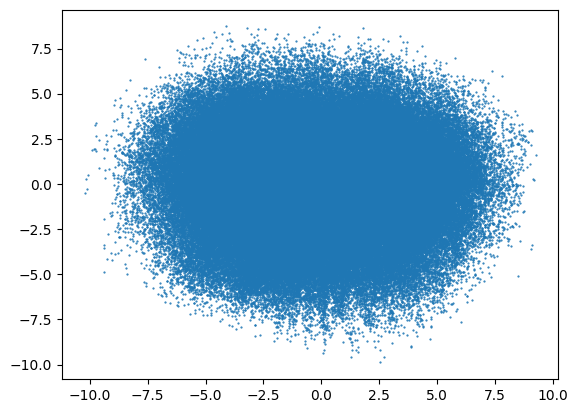

In [14]:
transformer = PCA(n_components=2)
transformed = transformer.fit_transform(latent_space)
plt.figure()
plt.scatter(transformed[:, 0], transformed[:, 1], s=0.3)
plt.show()

In [8]:
mean = latent_space.mean(axis=0)
stddev = latent_space.std(axis=0)
print(f"Mean: {' '.join(f'{x:>8.2f}' for x in mean)}")
print(f"Stddev:  {' '.join(f'{x:>8.4f}' for x in stddev)}")

Mean:    -0.63     0.65     0.73    -0.14    -0.44     0.64    -1.53     2.45    -0.05    -0.32
Stddev:    2.4507   2.3222   2.0767   2.4810   2.5092   2.3760   1.8082   1.4824   2.4834   2.1819


In [9]:
print(f"Average standard deviation: {stddev.mean():.4f}")

Average standard deviation: 2.2172


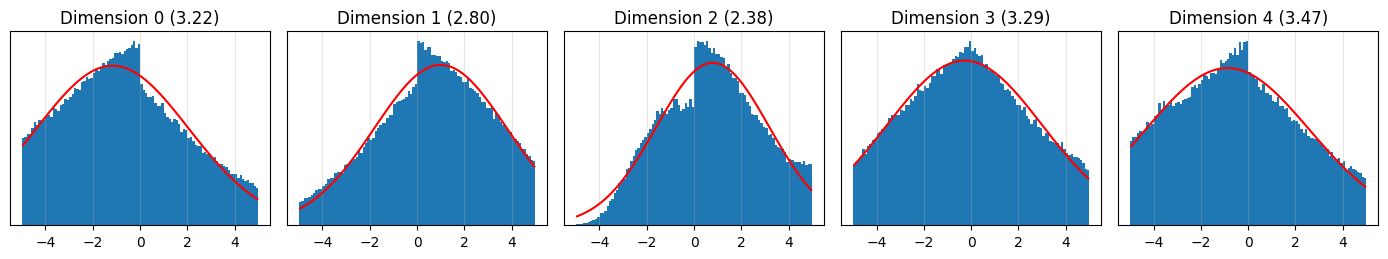

In [10]:
gauss = lambda x, A, mu, stdev: A * np.exp(-0.5 * ((x - mu) / stdev) ** 2)
# fig, axs = plt.subplots(nrows=5, figsize=(3, 12))
fig, axs = plt.subplots(ncols=5, figsize=(14, 2.7))
for i in range(5):
    hist, bin_edges = np.histogram(latent_space[:, i], bins=100)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    params = curve_fit(gauss, bin_centers, hist, p0=[1, mean[i], stddev[i]])[0]
    axs[i].bar(bin_centers, hist, width=1 * (bin_edges[1] - bin_edges[0]))
    axs[i].plot(bin_centers, gauss(bin_centers, *params), color='red')
    axs[i].set(title=f"Dimension {i} ({params[-1]:.2f})", yticks=[])
    axs[i].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
max_molecules_per_box = 15
n_boxes = molecule_count / max_molecules_per_box
n_box_steps = n_boxes ** (1 / 5)
n_boxes_per_dimension = int(np.ceil(n_box_steps))
print(f"Boxes per dimension: {n_boxes_per_dimension}")

bins = norm.ppf(np.linspace(0, 1, n_boxes_per_dimension + 1))
print(f"Bins: {' '.join(f'{b:.2f}' for b in bins)}")

Boxes per dimension: 25
Bins: -inf -1.75 -1.41 -1.17 -0.99 -0.84 -0.71 -0.58 -0.47 -0.36 -0.25 -0.15 -0.05 0.05 0.15 0.25 0.36 0.47 0.58 0.71 0.84 0.99 1.17 1.41 1.75 inf


In [8]:
def clusterize(latent_space):
    latent_space = (latent_space - mean) / stddev
    clusters = np.digitize(latent_space, bins) - 1 # np.digitize min index is 1
    return clusters.tolist()

In [ ]:
updates = []
log_file = open("log.txt", "w")
for i, mol in enumerate(collection.find()):
    latent_space = mol['latent_space']
    clusters = clusterize(latent_space)
    group = ' '.join(list(map(str, clusters)))
    updates.append(UpdateOne({"_id": mol["_id"]}, {
        "$set": {"group": group},
    }))
    if len(updates) >= 10_000:
        print(f"{i + 1:,}/{molecule_count:,}", end="\r")
        collection.bulk_write(updates)
        updates = []
    if i % 100_000 == 0:
        log_file.write(f"{i + 1:,}/{molecule_count:,}\n")
        log_file.flush()
if len(updates) > 0:
    collection.bulk_write(updates)
log_file.close()

In [ ]:
collection.create_index("group")

In [ ]:
def get_groups():
    addition = np.ones(5) * 10
    index_list = [' '.join(list(map(str, el))) for el in (np.array(list(product((-1, 0, 1), repeat=5))) + addition).astype(int)]
    count = 0
    for _ in collection.find({"group": {"$in": index_list}}):
        count += 1
    print(count)

%time get_groups()

1396
CPU times: user 53.3 ms, sys: 0 ns, total: 53.3 ms
Wall time: 2.13 s


In [12]:
def count_in_cell():
    count = 0
    for _ in collection.find({"group": ' '.join(list(map(str, [13, 5, 5, 8, 11])))}):
        count += 1
    print(count)

%time count_in_cell()

38
CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 125 ms


In [13]:
print('Random molecule:', next(iter(collection.aggregate([{"$sample": {"size": 1}}])))['name'])

Random molecule: Q1+ SC5 SQ1- SX4,0-1 0-2 0-3
